#**RECURSOS**

---



##PACKAGES

In [107]:
!pip install workalendar
!pip install pickle # Saving and loading objects 

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


##LIBRARIES

In [108]:
#DATA
import numpy as np 
import pandas as pd 
import time

#SPLIT DATA
from sklearn.model_selection import train_test_split

#CROSS VALIDATE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit


# METRICS 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

#PLOTS
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline


# Tensor flow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential

#WARNINGS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore')


import pickle # Saving and loading objects 


##FUNCTIONS

Tratment

In [109]:
# https://towardsdatascience.com/missforest-the-best-missing-data-imputation-algorithm-4d01182aed3

In [110]:
from sklearn.impute import SimpleImputer
import xgboost as xgb

def format_name_column(name_model):
    """
        Format the name of colunm.

        >Exemple

        full name: AAT.ASN.010.FIT.001.000.000
        initial name: 001 = 1
        initial name: VZ + 1
        importance: AAT.ASN.010
        
        name column: VZ1.AAT.ASN.010
    """
    name_column = name_model[0:11]
    name_ini = name_model[16:19]
    name_column = 'VZ'+str(int(name_ini))+'.'+name_column

    return name_column

def create_features(df,label=None,inplace=0):
    """
        Creates time series features from datetime index.
    """
    if inplace:
      date = df.copy()
    else:
      date = df

    date['date'] = df.index

    date['hour'] = date['date'].dt.hour
    date['dayofweek'] = date['date'].dt.dayofweek
    date['quarter'] = date['date'].dt.quarter
    date['month'] = date['date'].dt.month
    date['dayofyear'] = date['date'].dt.dayofyear
    date['dayofmonth'] = date['date'].dt.day
    date['weekofyear'] = date['date'].dt.weekofyear


    X = date[['hour','month','dayofweek','F','N','Q']]


    if label:
        y = df[label]
        return X,y
    return X


def remove_bad(x):
    """
        Remove string 'Bad' of the data base.
    """
    if(x == 'Bad'):
        return 0
        
    return x 
      

def clear_outliers(df,label,inplace=None):
  
    """ 
        Clear the outliers of data base 
        John Tukey method
    """

    if inplace:
      df_out = df 
    else:
      df_out = df.copy()
    sc = StandardScaler()
    
    # iforest = IsolationForest(n_estimators=150, max_samples='auto', 
    #                           contamination=0.008, max_features=1.0, 
    #                           bootstrap=False, n_jobs=-1, random_state=1)
    
    # pred = iforest.fit_predict(df_out[label].values.reshape(-1,1))
    # outlier_index = np.where(pred==-1)
    # df_out[label].iloc[outlier_index] = np.nan

    sc.fit(df_out[label].values.reshape(-1,1))
    for dofw in df_out.index.dayofweek.unique(): # Day of Week
        for h in df_out.index.hour.unique(): # Hours of day
              
              # Data Frame that contain 
              df_aux = df_out.loc[(df_out.index.dayofweek == dofw) & (df_out.index.hour == h),[label]]
              df_aux[label] = sc.transform(df_aux[label].values.reshape(-1,1))
              
              # Quartiles
              Q3 = df_aux.FLOW.quantile(0.75)

              Q1 = df_aux.FLOW.quantile(0.25)
              IQR = Q3 - Q1 # Interquantile
              
              # >>> Detection outliers and replace this values to nan.
              # Amplitudes:
              # lower limit = (Q1 - 1.5 * IQR)
              # upper limit = (Q3 + 1.5 * IQR)
              df_aux.loc[(df_aux[label] < (Q1 - 1.5 * IQR)) | (df_aux[label] > (Q3 + 1.5 * IQR))] = np.nan # Replace outliers for Nan
              
              # Imputation transformer for completing missing values.
              smpl = SimpleImputer(missing_values=np.NaN,strategy="median")
              
              # Fit model and replace the values Nan to the median
              # Build Data Frame whith ajusted values

              idf = pd.DataFrame(smpl.fit_transform(df_aux))

              # Define columns and index of the Data Frame
              idf.columns = df_aux.columns
              idf.index = df_aux.index

              idf[label] = sc.inverse_transform(idf[label].values.reshape(-1,1))
              # Overwrite outliers to the new values ajusted 
              df_out.loc[(df_out.index.dayofweek == dofw) & (df_out.index.hour == h),[label]] = idf[[label]]
      
    if inplace == 0:
      return df_out 

Models

In [111]:
def load_model(path,name):
    # Load model 
    meu_arquivo = open(path + name,'rb') # Read file binary (rb)
    model_predict = pickle.load(meu_arquivo) # Load model

    return model_predict


def save_model(model,path,name):
    # >>> Save model trained
    my_file = open(path+name+'.p','wb') # Open archive for write(w) in binary(b)
    pickle.dump(model, my_file) # Discharges model in archive .p
    my_file.close() # Close archive
    

Metrics

In [112]:
def metrics_regression(y_true,y_pred):
    d = {}
    d['mean squared error'] = mean_squared_error(y_true, y_pred)
    d['root mean Squared error'] = mean_squared_error(y_true, y_pred,squared=False)
    d['median absolute error'] = median_absolute_error(y_true, y_pred)
    d['mean absolute error'] = mean_absolute_error(y_true, y_pred)
    d['r2 score'] = r2_score(y_true, y_pred)
    d['simetric mean absulute percentage error'] = smape(y_true, y_pred)
    return d

def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)


def cross_val_score_predict(model,X_test,y_test,cv):

  result_crossval= {'SMAPE':[],'MSE':[],'MAE':[]}

  for train_idx,test_idx in cv.split(X_test):

      # model = model.fit(X_train.iloc[train_idx],y_train[train_idx],X_train.iloc[test_idx],y_test[test_idx])

      pred = model.predict(X_test.iloc[test_idx],y_test[test_idx])

      result_crossval['SMAPE'].append(smape(y_test[test_idx],pred))
      result_crossval['MSE'].append(mean_squared_error(y_test[test_idx],pred))
      result_crossval['MAE'].append(mean_absolute_error(y_test[test_idx],pred))
  return result_crossval

In [113]:
smape_score = make_scorer(smape)
mean_squared_error_score = make_scorer(mean_squared_error)
mean_absolute_error_score = make_scorer(mean_absolute_error)

#**1 Coleta de dados**

---






In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [179]:
path = '/content/drive/MyDrive/GitHub/Deep Learning/Regressão de vazão TF/Data/'

In [180]:
file_targets = path+r'train_flow_tf.xlsx'
file_features = path+r'inmet_tf.xlsx'

In [183]:
# Read target columns
df_flows = pd.read_excel(file_targets,index_col='DATE',usecols=columns) 

# Read feature columns
df_features = pd.read_excel(file_features,index_col='DATE')




#**2 Tratamento e entendimento dos dados**

---



Utilizando a função describe podemos verificar a existencia de outliers do tipo string com o nome 'BAD'. 

Faremos a troca dos registros com falha por nulos e a da tipagem de coluna para Real.

In [184]:
x = df_features.reset_index(drop=True)
y = df_flows.reset_index()

column = y.columns[1]

# Treatment of data

df = pd.concat([round(y,2),round(x)],axis=1) # Concat the target column and the features columns
df.set_index('DATE',inplace=True) # Set index of Data Frame
df.rename({column:'FLOW'},axis=1,inplace=True) # Rename column to FLOW

# Treat values 'Bad' and define type of column 'FLOW'
df['FLOW'] = df['FLOW'].apply(remove_bad)
df['FLOW'] = df['FLOW'].astype(float)

create_features(df,inplace=1).head(6)

,hour,month,dayofweek,F,N,Q
DATE,,,,,,
2020-01-01 00:00:00,0,1,2,20.0,89,1.0
2020-01-01 01:00:00,1,1,2,20.0,91,0.0
2020-01-01 02:00:00,2,1,2,20.0,93,1.0
2020-01-01 03:00:00,3,1,2,20.0,91,1.0
2020-01-01 04:00:00,4,1,2,20.0,87,1.0
2020-01-01 05:00:00,5,1,2,19.0,89,1.0


In [185]:
df_flows.describe().T

,count,unique,top,freq
AAT.TAG.110.FIT.001.000.000,8784,8702,Bad,42


In [186]:
pd.concat([df_flows,df_features],axis=1).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   AAT.TAG.110.FIT.001.000.000  8784 non-null   object 
 1   A                            8784 non-null   float64
 2   B                            8784 non-null   float64
 3   C                            8784 non-null   float64
 4   D                            8784 non-null   float64
 5   E                            8784 non-null   float64
 6   F                            8784 non-null   float64
 7   G                            8784 non-null   float64
 8   H                            8784 non-null   float64
 9   I                            8784 non-null   float64
 10  J                            8784 non-null   float64
 11  K                            8784 non-null   float64
 12  L                            8784 non-nu

Agora podemos utilizar a função describe novamente para analisar os dados numericos. Já na descrição dos nossos dados, podemos observar que nosso dado objetivo tem seu valor minimo sendo 0, o que pode significar possiveis outliers dado a natureza dos nossos dados.



In [187]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
FLOW,8784.0,98.221258,1.814830e+01,0.0,82.435981,102.524233,1.125393e+02,1.342335e+02
A,8784.0,0.175205,1.195525e+00,0.0,0.000000,0.000000,0.000000e+00,3.800000e+01
B,8784.0,887.670993,2.425696e+00,880.0,886.000000,888.000000,8.890000e+02,8.960000e+02
C,8784.0,887.915870,2.402389e+00,880.0,886.000000,888.000000,8.900000e+02,8.960000e+02
D,8784.0,887.424294,2.432691e+00,880.0,886.000000,887.000000,8.890000e+02,8.960000e+02
E,8784.0,716340.418147,1.072303e+06,-3538.0,-4.000000,1686.500000,1.291806e+06,4.205291e+06
F,8784.0,21.348702,3.958842e+00,9.0,19.000000,21.000000,2.400000e+01,3.600000e+01
G,8784.0,13.968010,4.488451e+00,-3.0,10.000000,15.000000,1.800000e+01,2.100000e+01
H,8784.0,22.051913,4.065729e+00,9.0,19.000000,22.000000,2.500000e+01,3.600000e+01
I,8784.0,20.683174,3.844958e+00,8.0,18.000000,20.000000,2.300000e+01,3.400000e+01


O que podemos observar no grafico de de vazão são outliers artificiais multivariados. Artificiais pois são gerados possivelmente por falhas na medição e processamento.




Plotando o grafico de vazão de água é possivel observar claramente as falhas que existem na série histórica.

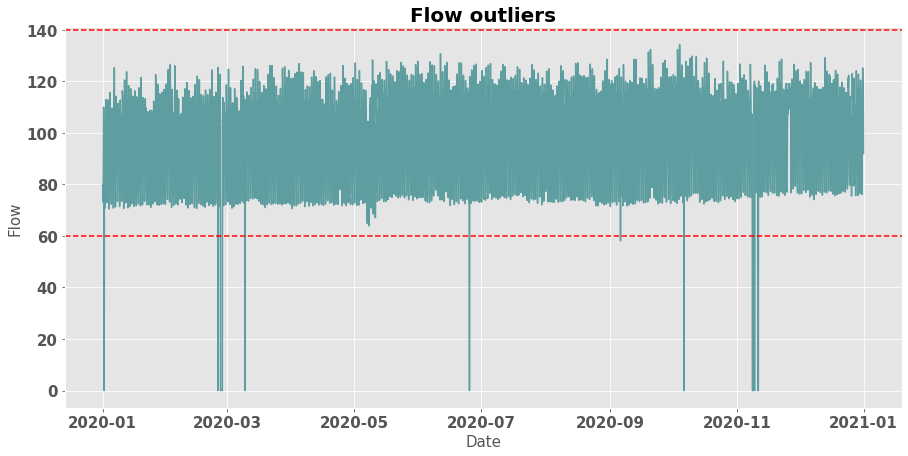

In [188]:
# OUTLIER E ERROS DE MEDIÇÃO
plt.subplots(figsize=(15,7))
data = df.FLOW
plt.plot(data.index,data.values,color='#5F9EA0')
plt.axhline(y=60,linestyle='--',color='#FE0202',linewidth=1.5)
plt.axhline(y=140,linestyle='--',color='#FE0202',linewidth=1.5)
plt.title('Flow outliers',fontweight='bold',fontsize=20)
plt.xticks(fontsize=15,fontweight='bold')
plt.yticks(fontsize=15,fontweight='bold')
plt.ylabel('Flow',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.show()

**Tratamento de outliers**


Existem várias formas robustas de se tratar outliers hoje em dia. Neste artigo iremos demonstrar a utilização do Metodo de Tukey.

**Método de Tukey**





O método de Tukey ou bloxplot consiste em definir os limites inferior e superior a partir do interquantil (IQR) e dos primeiros(Q1) e terceiros quartis(Q3).

***Mas o que são quartis?***

Quartis são separatrizes que que dividem um conjunto de dados em 4 partes iguais. O objetivo das separatrizes é proporcionar uma melhor idéia da dispersão do conjunto de dados, principalmente da simetria ou assimetria da
distribuição. 

<image src='https://miro.medium.com/max/1246/1*0MvBAT8zFSOt6sfEojbI-A.png' width=520 height=200>




O limite inferior é definido pelo primeiro quartil menos o produto entre o valor 1.5 e o interquartil.

𝐿𝑖𝑛𝑓 = 𝑄1 − (1.5 ∗ 𝐼𝑄𝑅)


O limite inferior é definido pelo terceiro quartil mais o produto entre o valor 1.5 e o interquartil.

𝐿𝑠𝑢𝑝 = 𝑄3 + (1.5 ∗ 𝐼𝑄𝑅)




Para realizar o melhor tratamento possivel dos dados iremos dividir os dados e tratalos por subconjuntos divididos por dia da semana, hora e mês.
Em seguida faremos a troca desses outliers detectados pelo método de Tukey por nulos e em seguida preencheremos os nulos com a média de cada subconjunto.

In [189]:
# LIMPEZA
clear_outliers(df,'FLOW',inplace=1)

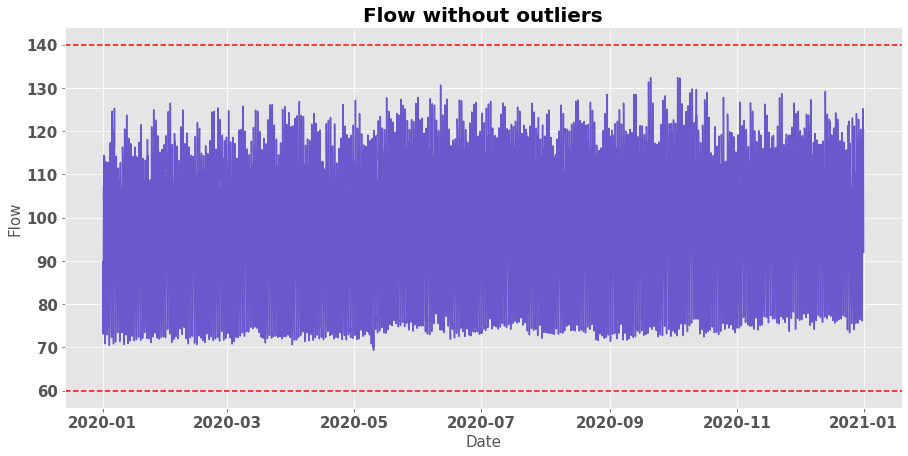

In [190]:
# OUTLIER REMOVIDOS
plt.subplots(figsize=(15,7))
data = df.FLOW
plt.plot(data.index,data.values,color='#6959CD')
plt.axhline(y=60,linestyle='--',color='#FE0202',linewidth=1.5)
plt.axhline(y=140,linestyle='--',color='#FE0202',linewidth=1.5)
plt.title('Flow without outliers',fontweight='bold',fontsize=20)
plt.xticks(fontsize=15,fontweight='bold')
plt.yticks(fontsize=15,fontweight='bold')
plt.ylabel('Flow',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.show()

In [191]:
from scipy.stats import variation 
print('Coeficiente de variação:',variation(df['FLOW'], axis=0))

Coeficiente de variação: 0.16278366360535446


**Distribuição normal**

Como o modelo XGBoost não precisa de normalização nem padronização das variaveis, não iremos nos preocupar em realizar esses procedimentos.

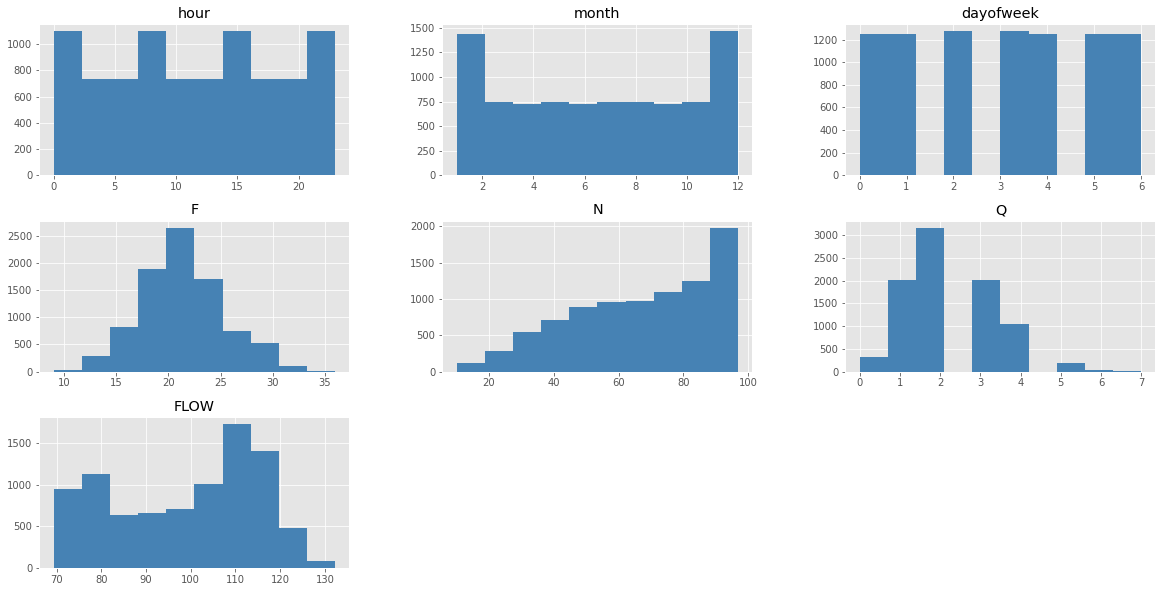

In [192]:
fig,ax = plt.subplots(figsize=(20,10))
pd.concat(create_features(df,'FLOW'),axis=1).hist(ax=ax,color =	'#4682B4')
plt.show()

#**3 Sepração dos dados**

---



In [168]:
df_ml = df.copy()

test_size = 0.2
flow_train, flow_test = train_test_split(df_ml, test_size=test_size,random_state=43)

# Creates new feature columns
X_train, y_train = create_features(flow_train, label='FLOW')
X_test, y_test   = create_features(flow_test[:int(len(flow_test)*0.5)], label='FLOW')
X_eval, y_eval  = create_features(flow_test[int(len(flow_test)*0.5):], label='FLOW')

# For plot
train, test = train_test_split(pd.concat(create_features(df_ml, label='FLOW'),axis=1), test_size=0.1,shuffle=False)

#**4 Processamento com redes neurais**
---



In [169]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [170]:
x_train_tf = scaler.fit_transform(X_train)
x_test_tf = scaler.fit_transform(X_test)

y_train_tf = y_train
y_test_tf = y_test

In [131]:
def build_model():
  model = Sequential([
    Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    Dense(64, activation='relu'),
    Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [132]:
model_tf = build_model()

EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model_tf.fit(x_train_tf,y_train_tf, epochs=EPOCHS,validation_split = 0.2, verbose=1)

loss, mae, mse = model_tf.evaluate(x_test_tf,y_test_tf, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} FLOW".format(mae))

Epoch 1/1000
176/176 [==============================] - 1s 3ms/step - loss: 5428.5239 - mae: 66.9534 - mse: 5428.5239 - val_loss: 276.3002 - val_mae: 13.4462 - val_mse: 276.3002
Epoch 2/1000
176/176 [==============================] - 0s 2ms/step - loss: 193.0594 - mae: 11.2844 - mse: 193.0594 - val_loss: 155.5183 - val_mae: 9.8905 - val_mse: 155.5183
Epoch 3/1000
176/176 [==============================] - 0s 2ms/step - loss: 145.1488 - mae: 9.7655 - mse: 145.1488 - val_loss: 140.6020 - val_mae: 9.6149 - val_mse: 140.6020
Epoch 4/1000
176/176 [==============================] - 0s 2ms/step - loss: 136.2199 - mae: 9.4761 - mse: 136.2199 - val_loss: 133.0267 - val_mae: 9.3054 - val_mse: 133.0267
Epoch 5/1000
176/176 [==============================] - 0s 2ms/step - loss: 131.9293 - mae: 9.3408 - mse: 131.9293 - val_loss: 135.6417 - val_mae: 9.1776 - val_mse: 135.6417
Epoch 6/1000
176/176 [==============================] - 0s 2ms/step - loss: 130.0051 - mae: 9.2627 - mse: 130.0051 - val_loss

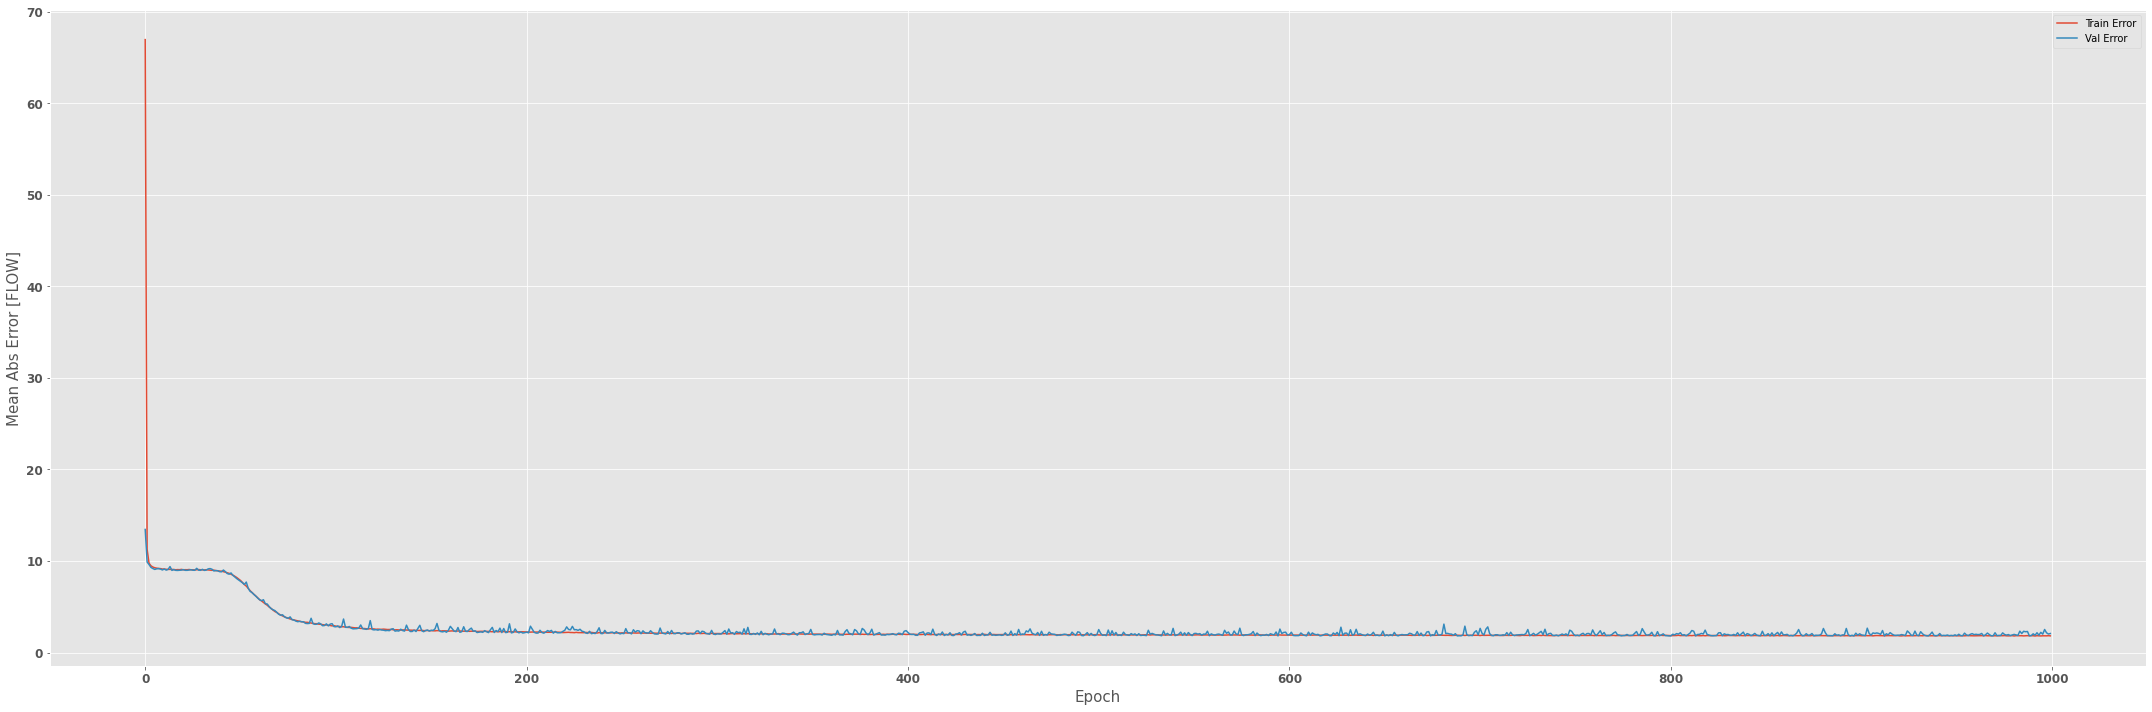

In [164]:

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.subplots(figsize=(30,10))
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Mean Abs Error [FLOW]',fontsize=15)
plt.plot(hist['epoch'], hist['mae'],label='Train Error')
plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
plt.yticks(fontweight='bold',fontsize=12)
plt.xticks(fontweight='bold',fontsize=12)
plt.legend()
plt.tight_layout()

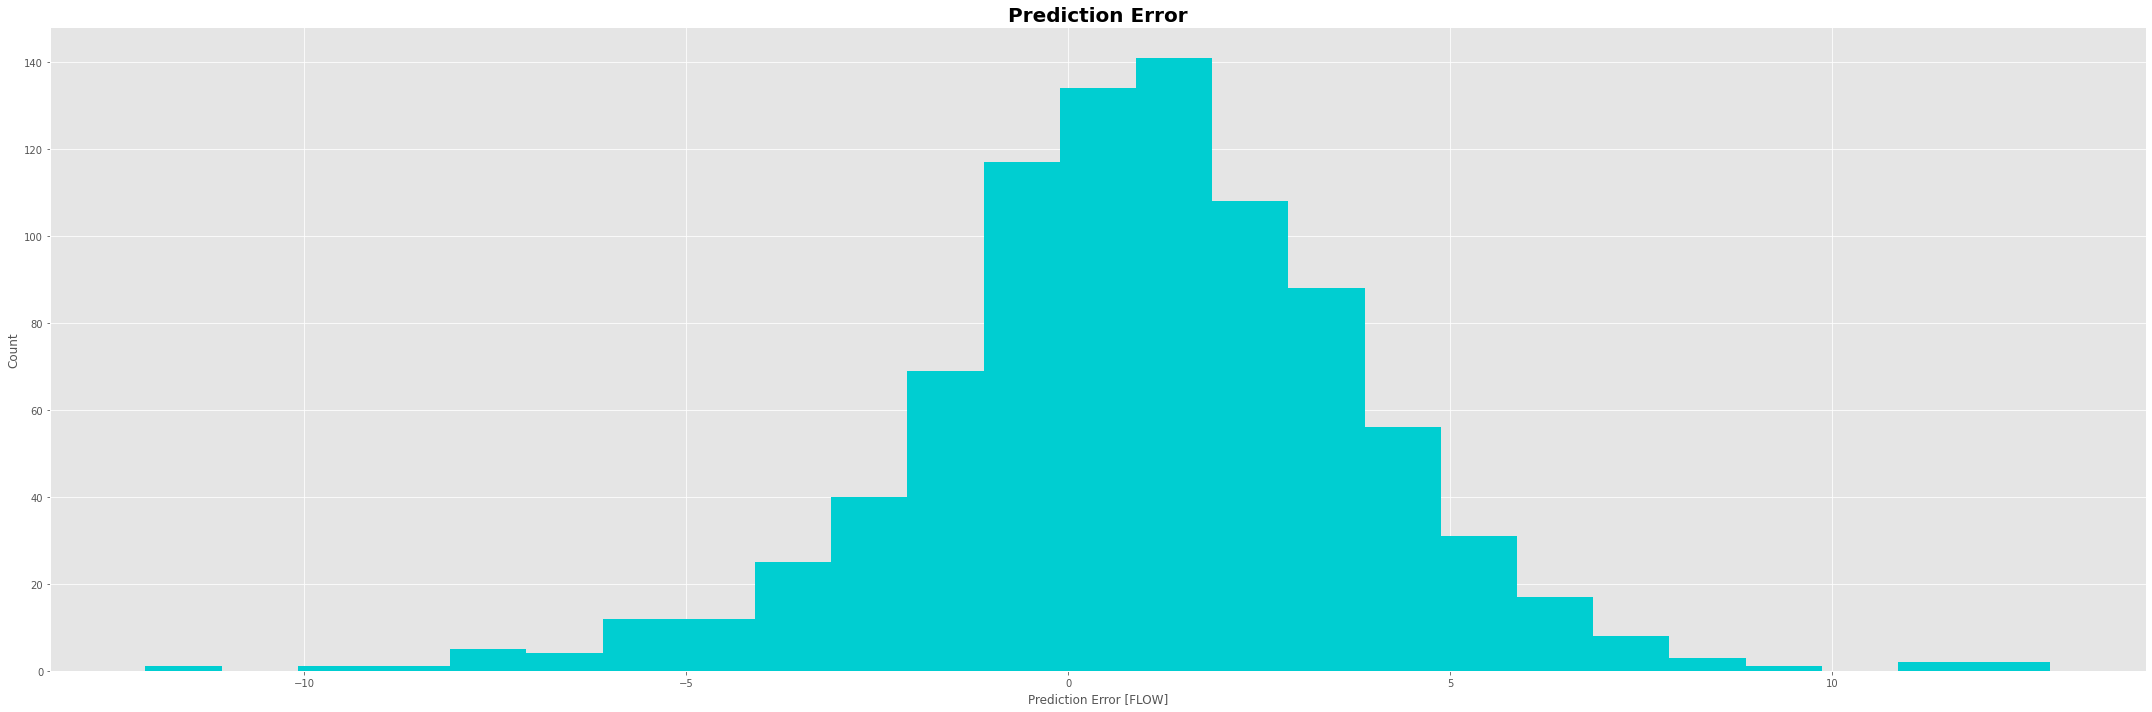

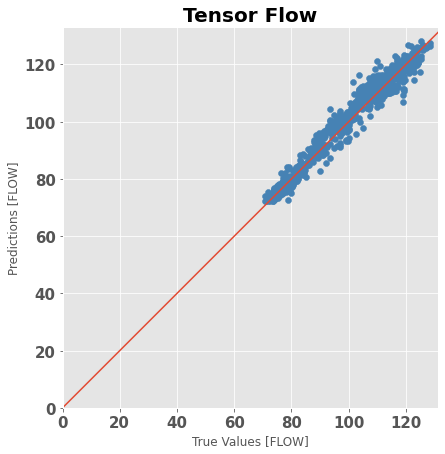

In [165]:
test_predictions = model_tf.predict(x_test_tf).flatten()

error = test_predictions - y_test_tf.values

plt.subplots(figsize=(30,10))

plt.hist(error, bins = 25,color='#00CED1')
plt.xlabel("Prediction Error [FLOW]")
plt.ylabel("Count")
plt.title('Prediction Error',fontsize=20,fontweight='bold')
plt.tight_layout()


plt.subplots(figsize=(15,7))
plt.scatter(y_test_tf.values, test_predictions,color=	'#4682B4')
plt.xlabel('True Values [FLOW]')
plt.ylabel('Predictions [FLOW]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.xticks(fontweight='bold',fontsize=15)
plt.yticks(fontweight='bold',fontsize=15)
plt.title('Tensor Flow',fontweight='bold',fontsize=20)
_ = plt.plot([-100, 300], [-100, 300])

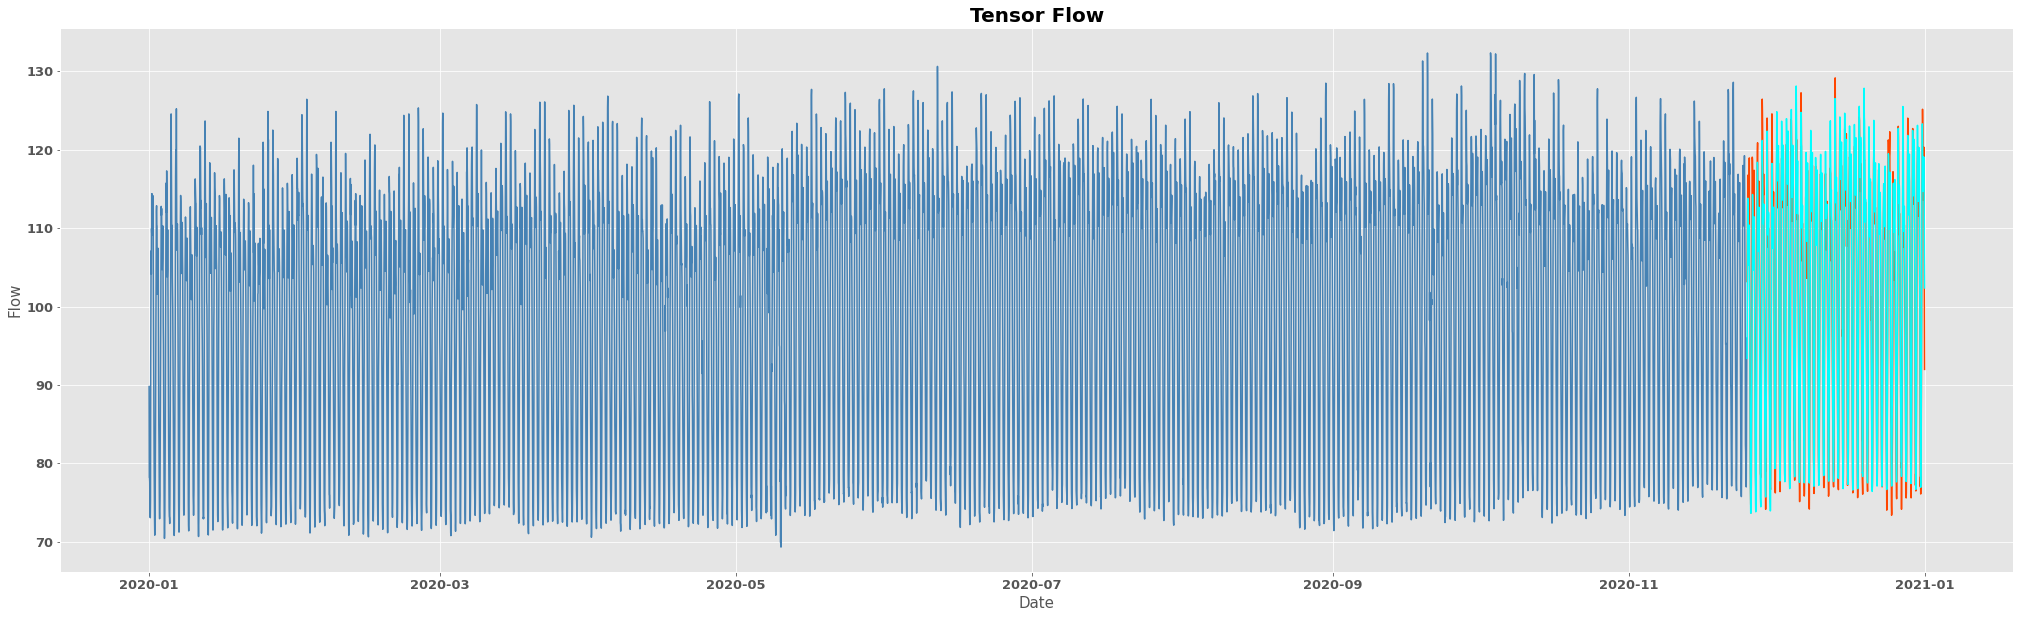

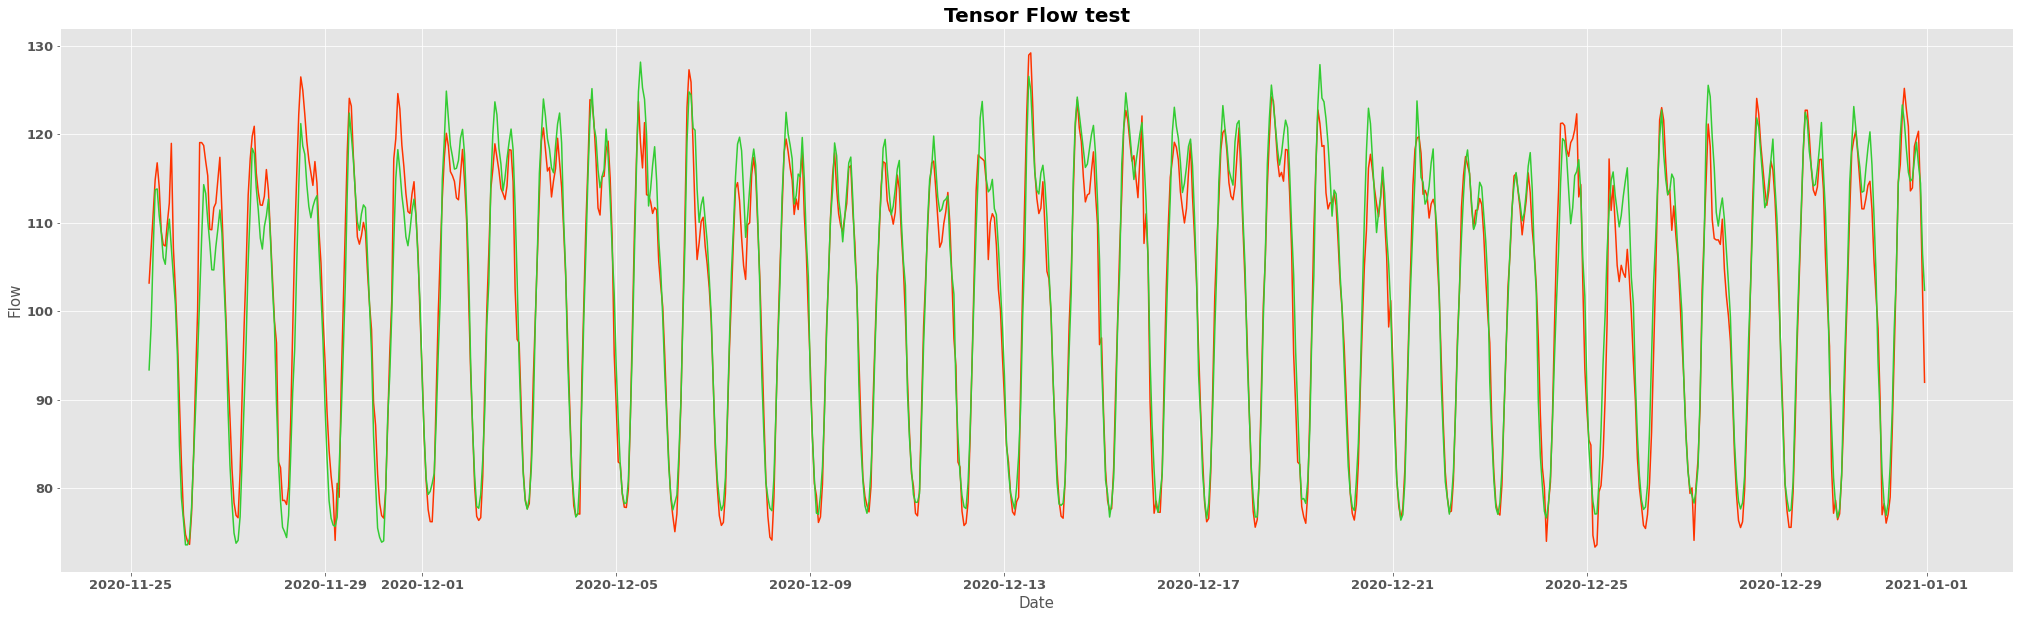

In [178]:
pred_tf = model_tf.predict(scaler.fit_transform(test.drop(['FLOW'],axis=1)))


plt.subplots(figsize=(35,10))
plt.plot(train.index,train['FLOW'],color='#4682B4')
plt.plot(test.index,test['FLOW'],color='#FF4500')
plt.plot(test.index,pred_tf,color='#00FFFF')
plt.title('Tensor Flow',fontsize=20,fontweight='bold')
plt.yticks(fontsize=13,fontweight='bold')
plt.xticks(fontsize=13,fontweight='bold')
plt.ylabel('Flow',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.show()

plt.subplots(figsize=(35,10))
plt.plot(test.index,test['FLOW'],color='#ff3300')
plt.plot(test.index,pred_tf,color='#33cc33')
plt.title('Tensor Flow test',fontsize=20,fontweight='bold')
plt.yticks(fontsize=13,fontweight='bold')
plt.xticks(fontsize=13,fontweight='bold')
plt.ylabel('Flow',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.show()

In [136]:
metrics_regression(y_test_tf.values, test_predictions)

{'mean absolute error': 2.325285852308792,
 'mean squared error': 9.191955544642912,
 'median absolute error': 1.8101985931396456,
 'r2 score': 0.9654677214839136,
 'root mean Squared error': 3.031823798416213,
 'simetric mean absulute percentage error': 2.3085724287945366}